In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics

from src.generate import load_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32

T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')

# train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count, batch_size=batch_size)

created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each


In [4]:
trained_reasoner.load_state_dict(T.load('local/out/exp/20220715T194304/reasoner.pt'))


<All keys matched successfully>

In [5]:
print(len(data_te[0]))
print(len(data_te[1]))
print(len(data_te[2]))

40000
40000
40000


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_test = pd.DataFrame({
    'ontology_id': data_te[0],
    'X': data_te[1],
    'y': data_te[2]
})

def stratified_group_split(data, group_col, stratify_col, test_size=0.2, val_size=0.2):
    groups = data[group_col].unique()
    train_idx, val_idx, test_idx = [], [], []

    for group in groups:
        group_data = data[data[group_col] == group]
        train_data, temp_data = train_test_split(group_data, test_size=(test_size + val_size), stratify=group_data[stratify_col], random_state=seed)
        val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size + val_size), stratify=temp_data[stratify_col], random_state=seed)

        train_idx.extend(train_data.index)
        val_idx.extend(val_data.index)
        test_idx.extend(test_data.index)

    return data.loc[train_idx], data.loc[val_idx], data.loc[test_idx]

train_data, val_data, test_data = stratified_group_split(data_test, 'ontology_id', 'y', test_size=0.2, val_size=0.2)

X_train = train_data['X'].tolist()
y_train = train_data['y'].tolist()
ontology_id_train = train_data['ontology_id'].tolist()

data_te_tr = [ontology_id_train,X_train, y_train] 

X_val = val_data['X'].tolist()
y_val = val_data['y'].tolist()
ontology_id_val = val_data['ontology_id'].tolist()

data_te_vl = [ontology_id_val, X_val, y_val] 

X_te = X_test = test_data['X'].tolist()
y_te = y_test = test_data['y'].tolist()
idx_te = ontology_id_test = test_data['ontology_id'].tolist()


In [7]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
random_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, data_te_vl, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 751/750 | loss 1.3681 | val loss 1.3720 | acc 0.5904 | f1 0.4052 | prec 0.2958 | recall 0.6429 | roc auc 0.6765 | pr auc 0.4963 | elapsed 6.92s
train epoch 01/10 | batch 751/750 | loss 1.2114 | val loss 1.0572 | acc 0.6542 | f1 0.4464 | prec 0.3420 | recall 0.6423 | roc auc 0.7187 | pr auc 0.5413 | elapsed 18.06s
train epoch 02/10 | batch 751/750 | loss 0.8961 | val loss 0.8088 | acc 0.7153 | f1 0.4978 | prec 0.4032 | recall 0.6503 | roc auc 0.7605 | pr auc 0.5921 | elapsed 17.15s
train epoch 03/10 | batch 751/750 | loss 0.6569 | val loss 0.6282 | acc 0.7700 | f1 0.5536 | prec 0.4782 | recall 0.6573 | roc auc 0.7997 | pr auc 0.6483 | elapsed 18.18s
train epoch 04/10 | batch 751/750 | loss 0.4876 | val loss 0.5028 | acc 0.8141 | f1 0.6123 | prec 0.5593 | recall 0.6763 | roc auc 0.8325 | pr auc 0.7037 | elapsed 17.67s
train epoch 05/10 | batch 751/750 | loss 0.3728 | val loss 0.4182 | acc 0.8471 | f1 0.6609 | prec 0.6371 | recall 0.6866 | roc au

In [8]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te, y_te, idx_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

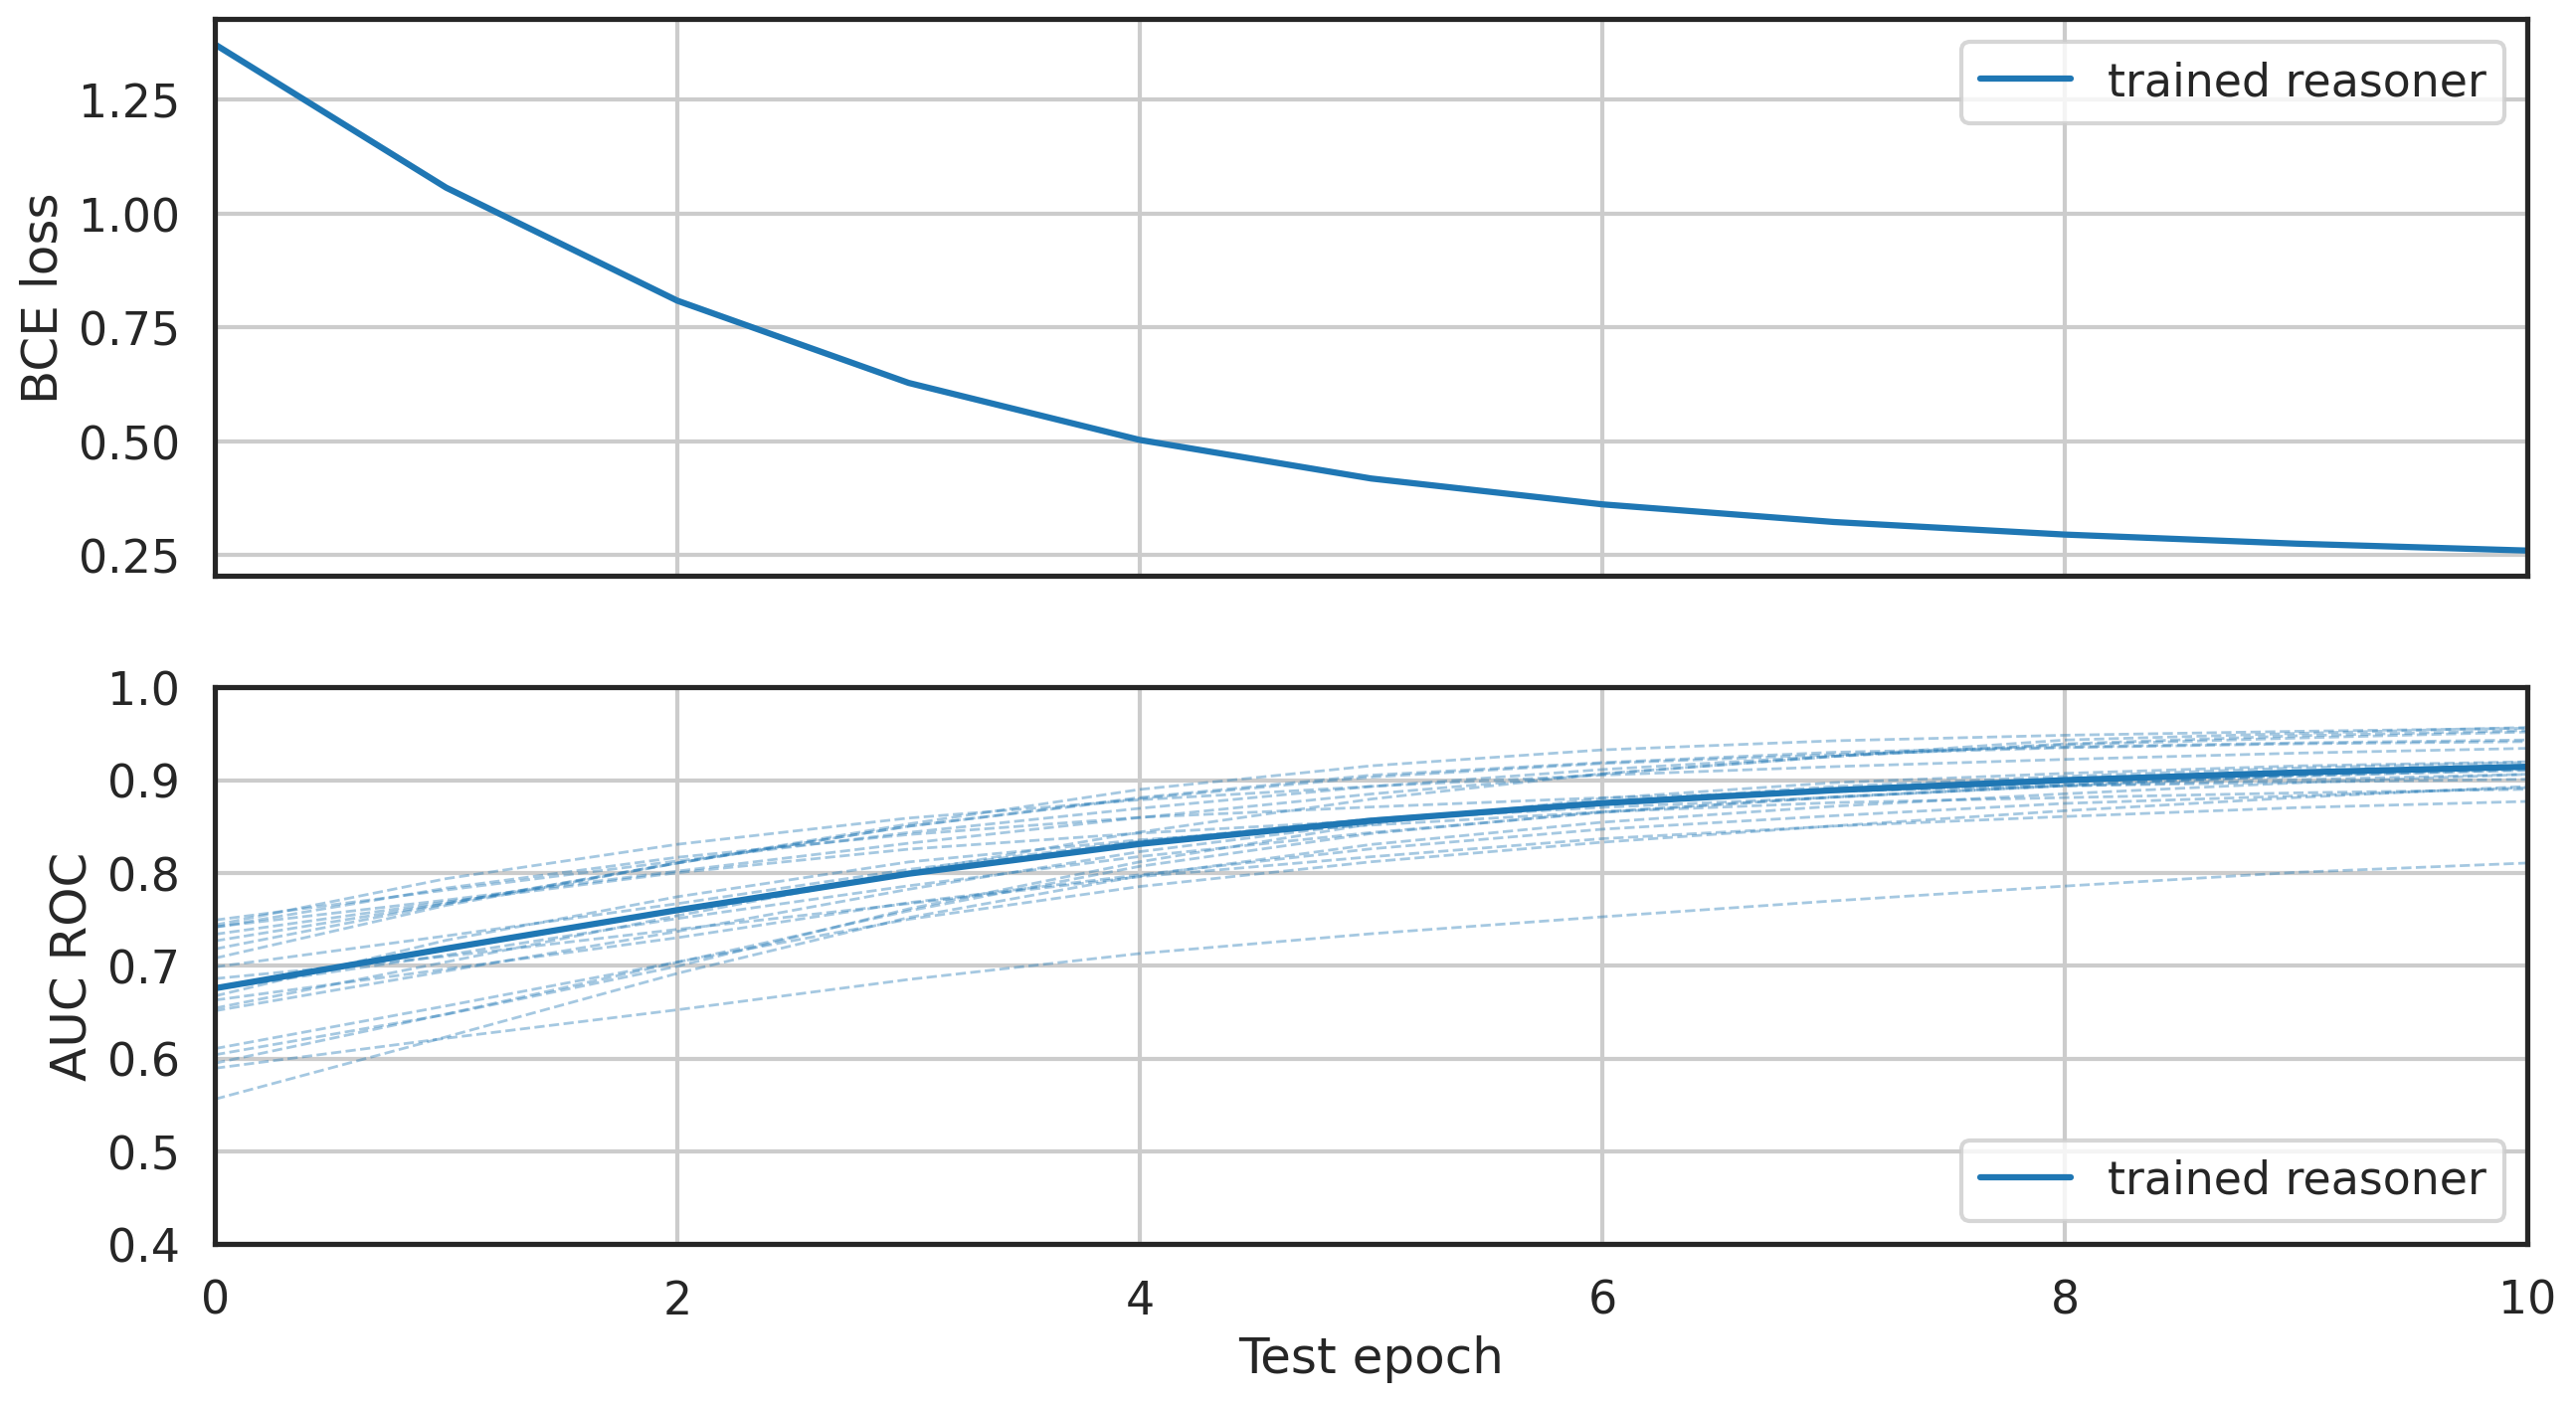

             mean       std     micro
acc      0.915250  0.024814  0.915250
prec     0.843452  0.065238  0.842004
recall   0.750018  0.067858  0.752151
f1       0.792777  0.059153  0.794545
auc_roc  0.915114  0.028213  0.916296
auc_pr   0.864812  0.044690  0.866237


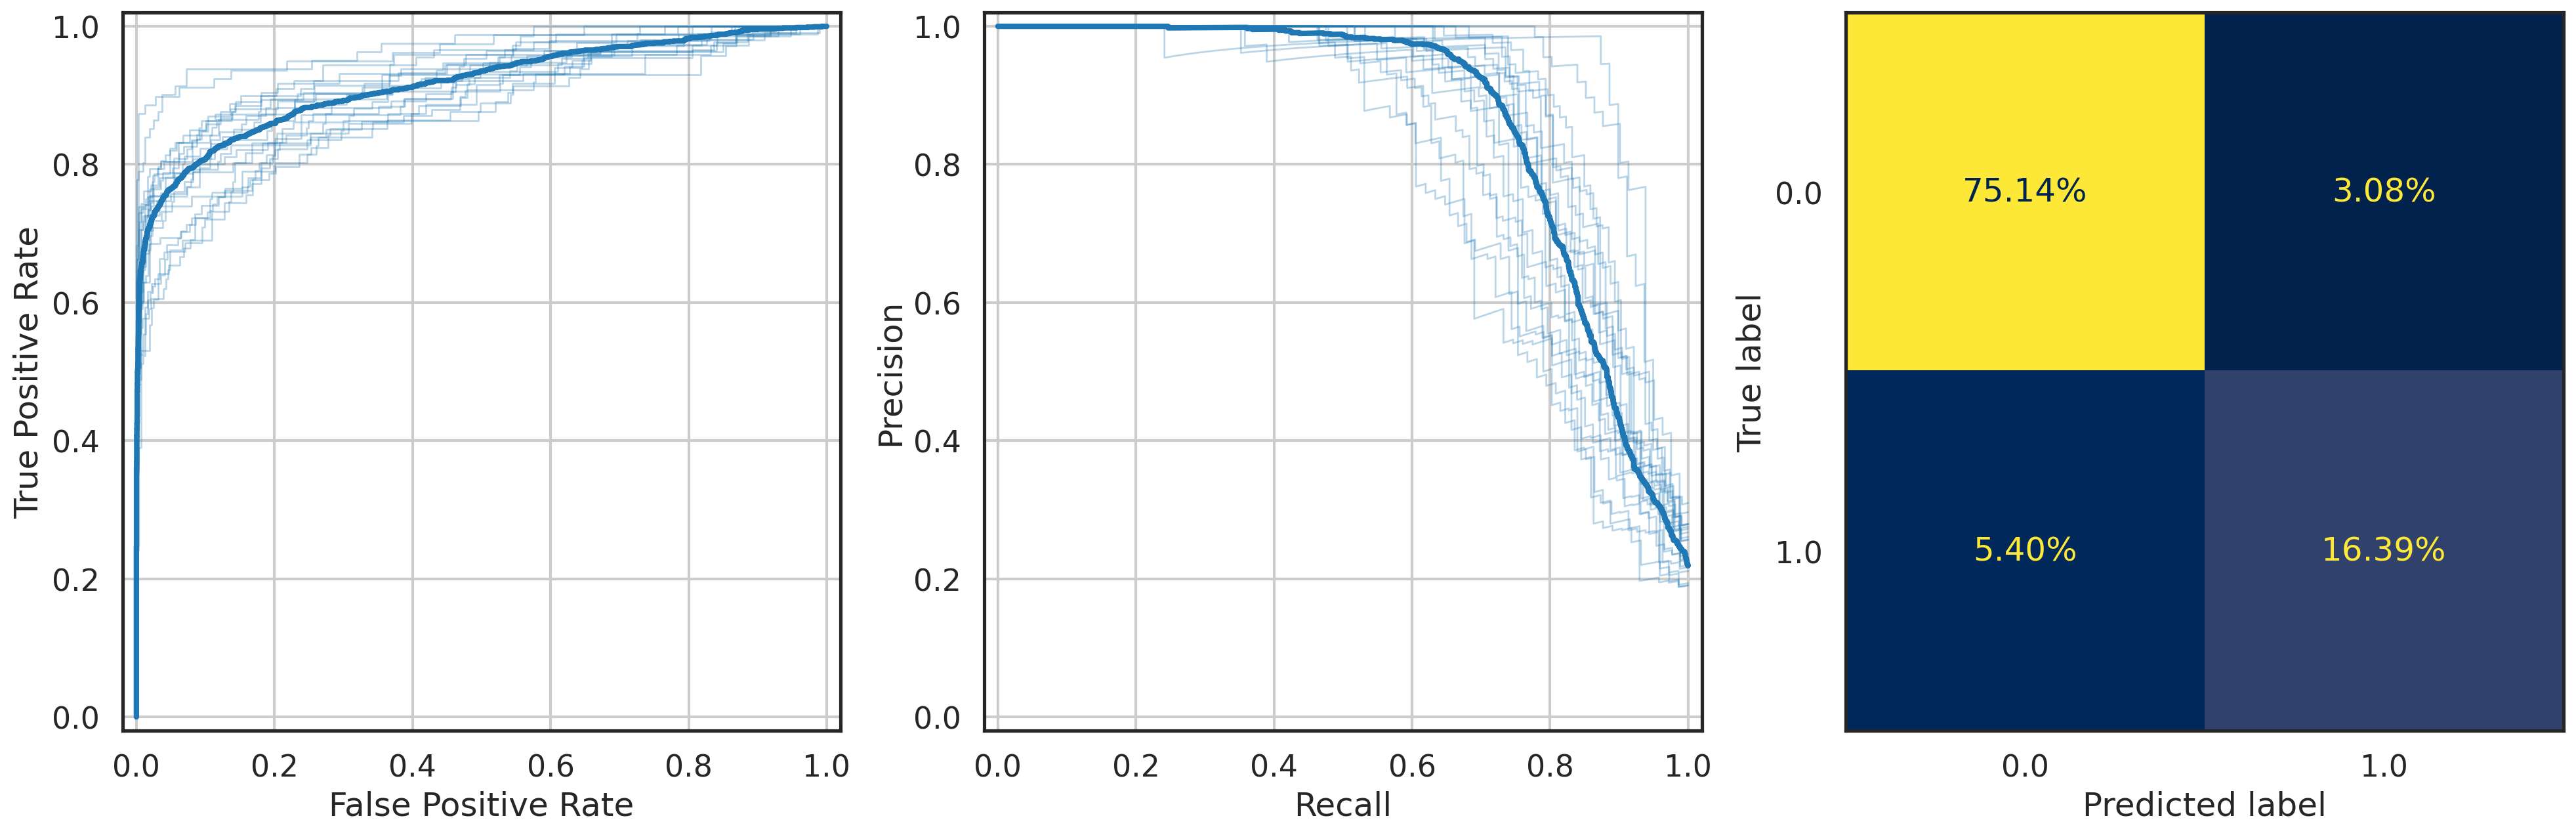

In [9]:
# base = 'local/out/exp/' + ts
# mkdirp(base)
# print(base)

# T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
# df_tr = pd.DataFrame(train_logger.history_tr)
# df_vl = pd.DataFrame(train_logger.history_vl)
# df_tr.to_csv(base+'/train.csv', index=False)
# df_vl.to_csv(base+'/valid.csv', index=False)
# plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te_good=Y_te_good))
# test_history.to_csv(base+'/test.csv', index=False)
# test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
# test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te, np.array(Y_te_good), idx_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [10]:
import random

In [11]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [12]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []
losses_reflexivity_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    reflexivity_subsumption = trained_reasoner.sub_nn(im(input1, input1))
    losses_reflexivity_subsumption.append(1 - T.sigmoid(reflexivity_subsumption).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [13]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Reflexivity of Subsumption", losses_reflexivity_subsumption, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.268157
  Std Dev Loss: 0.032014
  Mean Diff: 0.555188
  Std Dev Diff: 0.091460

Duality of Top and Bottom:
  Mean Loss: 0.379637
  Std Dev Loss: 0.000000
  Mean Diff: 0.702399
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.128961
  Std Dev Loss: 0.030261
  Mean Diff: 0.322653
  Std Dev Diff: 0.089586

Associativity:
  Mean Loss: 0.033884
  Std Dev Loss: 0.010021
  Mean Diff: 0.078489
  Std Dev Diff: 0.024085

Commutativity:
  Mean Loss: 0.036828
  Std Dev Loss: 0.012851
  Mean Diff: 0.086221
  Std Dev Diff: 0.030313

Contradiction:
  Mean Loss: 0.373903
  Std Dev Loss: 0.020112
  Mean Diff: 0.797649
  Std Dev Diff: 0.067028

Identity with Top:
  Mean Loss: 0.152149
  Std Dev Loss: 0.036632
  Mean Diff: 0.377536
  Std Dev Diff: 0.110058

Absorption by Bottom:
  Mean Loss: 0.373855
  Std Dev Loss: 0.018845
  Mean Diff: 0.730955
  Std Dev Diff: 0.028128

Top Concept Subsumption:
  Mean Loss: 0.000520
  Std Dev Loss: 0.000527
  Mean Diff: N/A
  Std De